In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyproj
from shapely.geometry import Point, Polygon

def create_grid(bottom_left, top_right, resolution):
    """
    Crea una malla geoespacial con una resolución dada, teniendo en cuenta la curvatura de la Tierra.

    :param bottom_left: tupla con las coordenadas del punto inferior izquierdo (latitud, longitud)
    :param top_right: tupla con las coordenadas del punto superior derecho (latitud, longitud)
    :param resolution: resolución de la malla en metros
    :return: dataframe que representa los puntos de la malla
    """

    # Definir la proyección de Mercator
    proj = pyproj.Proj(proj='merc')

    # Convertir las coordenadas geográficas en coordenadas cartesianas
    x1, y1 = proj(bottom_left[1], bottom_left[0])
    x2, y2 = proj(top_right[1], top_right[0])

    # Calcular la distancia en metros entre los puntos en la proyección de Mercator
    x_distance = x2 - x1
    y_distance = y2 - y1

    # Calcular el número de puntos en la malla en función de la resolución dada
    num_points_x = int(x_distance / resolution)
    num_points_y = int(y_distance / resolution)

    # Crear una matriz de coordenadas con la resolución dada en la proyección de Mercator
    x_coords = np.linspace(x1, x2, num_points_x)
    y_coords = np.linspace(y1, y2, num_points_y)
    coords = np.meshgrid(x_coords, y_coords)
    coords = np.dstack(coords).reshape(-1, 2)

    # Convertir las coordenadas cartesianas a coordenadas geográficas
    lon, lat = proj(coords[:,0], coords[:,1], inverse=True)

    # Crear un dataframe de pandas con las columnas 'Latitude' y 'Longitude' a partir de las coordenadas
    df = pd.DataFrame({'Latitude': lat, 'Longitude': lon})

    # Crear una geometría poligonal que encierra todos los puntos
    boundary = Polygon([(bottom_left[1], bottom_left[0]), (bottom_left[1], top_right[0]),
                        (top_right[1], top_right[0]), (top_right[1], bottom_left[0])])

    # Seleccionar solo los puntos que están dentro del polígono definido
    df = df[df.apply(lambda row: boundary.contains(Point(row.Longitude, row.Latitude)), axis=1)]

    return df

In [2]:
bott_left = [3.571, -74.638]
top_right = [5.057, -73.710]
res = 1000 #[m]

df = create_grid(bott_left, top_right, res)
print(len(df['Latitude'].tolist()))
df.head(10)

16564


,Latitude,Longitude
1,3.571,-74.628902
2,3.571,-74.619804
3,3.571,-74.610706
4,3.571,-74.601608
5,3.571,-74.592510
6,3.571,-74.583412
7,3.571,-74.574314
8,3.571,-74.565216
9,3.571,-74.556118
10,3.571,-74.547020


(-74.67439215686275, -73.67360784313723, 3.496700000000001, 5.131299999999999)

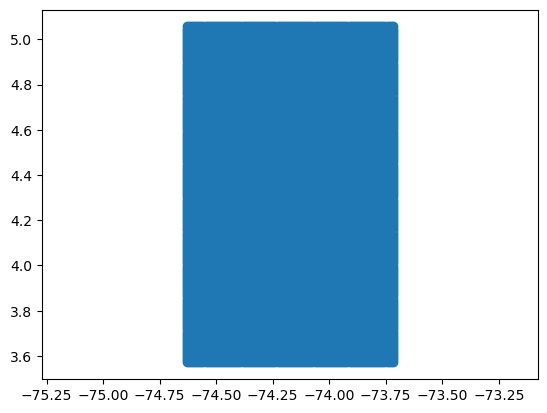

In [3]:
plt.scatter(df['Longitude'], df['Latitude'])
plt.axis('equal')

In [6]:
df.to_csv('malla_res_1km.csv', index=False)